DSCI100/002 Group 5

Project Proposal

Title: Decoding Legendary Pokemon 

Introduction:
Pokemon is an entertainment franchise that surrounds a make-believe world where people catch, train and battle animals known as Pokemon. They are created with various statistics, appearances and personalities. In these games we as the player create teams and travel across various regions to battle other trainers and wild Pokemon. All Pokemon have set statistics determining how powerful they are, with the highly desirable “Legendary Pokemon” having much higher statistics than most of the non-legendaries. 
Our predictive question is to determine whether a hypothetical Pokemon we create with random statistics should be considered legendary. We will analyze different selected variables of all the Pokemon up to the sixth generation to determine what constitutes a legendary and put our findings against our new Pokemon to determine if it is legendary or not. For our data, we are using the ‘Pokemon with Stats' dataset from Kaggle, containing the names of pokemon and all of their statistics, and a classification of either legendary or not legendary as variables. (source: https://www.kaggle.com/datasets/abcsds/pokemon)

Methods:
A classification model will be built, using the variables of attack, special attack, defense, special defense, and speed. These variables were chosen because they are the 5 traits that determine the overall strength/quality of a pokemon and there is typically a large difference in these values between legendary-tier pokemon and normal pokemon, so the predictor can be accurate using a nearest k-neighbors classifier. 
One way the results will be visualized is on a box plot, where the y axis is a total sum of all 5 predictor variables together, representing the overall strength of the pokemon. There will be four boxes, one box represents legendary pokemon, one represents non-legendary pokemon. Unknown classes will have 2 different boxes, one for legendary and one for non-legendary based on the prediction of the model. This will allow the reader to see the average stats of the different classes of pokemon, and whether the averages of the predictions match the averages of the known classifications.

Expected outcomes and significance:
This analysis is expected to demonstrate that our pokemon is classified as legendary if its attack, defense, special defense, and speed variables lie within the range of other legendary pokemon, and a non-legendary pokemon if they lie below it. 
Our findings can be used by game developers in using the statistics found to create legendary and non-legendary pokemon, as well as used by game players to analyze the strength and value of their own pokemon based on its own statistics. 
In the development of new pokemon, this analysis leads to the future question of what the threshold of the different attack, defense, special defense, and speed variables game developers can set for a legendary pokemon in order to ensure fairness of play between others.

In [3]:
#install.packages("themis")

In [4]:
#loading required libraries for the analysis. Install the packages if they are not previously installed.
library(rvest)
library(tidymodels)
library(themis)
library(tidyverse)
set.seed(100)

In [5]:
#Reading web data using GitHub generated URL link

url <- "https://raw.githubusercontent.com/dlee03/DSCI_group_project/main/Pokemon.csv" 
pokemon2 <- read_csv(url)
pokemon2

Rows: 800 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Name, Type 1, Type 2
dbl (9): #, Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Generation
lgl (1): Legendary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,FALSE
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,FALSE
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,FALSE
6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,FALSE
6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,FALSE
6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,FALSE


In [6]:
#remove spaces in names and replace with '.'

colnames(pokemon2) <- make.names(colnames(pokemon2)) 
pokemon2

X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,FALSE
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,FALSE
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,FALSE
6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,FALSE
6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,FALSE
6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,FALSE


In [7]:
#summarize data that reports number of entries per column 

pokemon_selected <- pokemon2 |>
    select(Name, Attack, Defense, Sp..Atk, Sp..Def, Speed, Legendary)
pokemon_selected

Name,Attack,Defense,Sp..Atk,Sp..Def,Speed,Legendary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Bulbasaur,49,49,65,65,45,FALSE
Ivysaur,62,63,80,80,60,FALSE
Venusaur,82,83,100,100,80,FALSE
VenusaurMega Venusaur,100,123,122,120,80,FALSE
Charmander,52,43,60,50,65,FALSE
Charmeleon,64,58,80,65,80,FALSE
Charizard,84,78,109,85,100,FALSE
CharizardMega Charizard X,130,111,130,85,100,FALSE
CharizardMega Charizard Y,104,78,159,115,100,FALSE


In [8]:
#find counts in each
pokemon_counts <- pokemon_selected |> 
    group_by() |>
    summarize(counts = n())
pokemon_counts

counts
<int>
800


In [9]:
sum(is.na(pokemon_counts)) #check if there is any missing data in the dataframe

[1] 0

In [10]:
#convert the character variable to the factor datatype
pokemon_data <- pokemon_selected |>
    mutate(Legendary = as_factor(Legendary)) 

In [11]:
#make training data set
pokemon_split <- initial_split(pokemon_selected, prop = 0.75, strata = Legendary)
pokemon_train <- training(pokemon_split)
pokemon_test <- testing(pokemon_split)
#convert Legendary column into factor instead of boolean for both training and testing data
pokemon_train <- pokemon_train |>
    mutate(Legendary = as_factor(Legendary)) 
pokemon_test <- pokemon_test |>
    mutate(Legendary = as_factor(Legendary)) 

In [12]:
#table of the mean stats of the training set pokemon, and the number of pokemon used in the training set.
nrow(pokemon_train)
mean_stats_table <- pokemon_train |> 
    summarize(across(Attack:Speed, mean)) |>
    add_column(n_training_pokemon = 600)
mean_stats_table

[1] 600

Attack,Defense,Sp..Atk,Sp..Def,Speed,n_training_pokemon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
79.845,74.08167,72.98833,70.38167,68.60833,600


In [19]:
#create a recipe and model for the analysis

pokemon_recipe <- recipe(Legendary ~ Attack +  Defense + Speed + Sp..Atk + Sp..Def, data = pokemon_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(Legendary, over_ratio = 1, skip = TRUE)

pokemon_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9300000,10,0.009229582,Preprocessor1_Model01
2,accuracy,binary,0.9300000,10,0.009229582,Preprocessor1_Model02
3,accuracy,binary,0.9166667,10,0.008240221,Preprocessor1_Model03
4,accuracy,binary,0.9150000,10,0.008407081,Preprocessor1_Model04
5,accuracy,binary,0.9050000,10,0.007876359,Preprocessor1_Model05
6,accuracy,binary,0.9050000,10,0.007876359,Preprocessor1_Model06
7,accuracy,binary,0.8950000,10,0.007876359,Preprocessor1_Model07
8,accuracy,binary,0.8950000,10,0.007876359,Preprocessor1_Model08
9,accuracy,binary,0.8850000,10,0.006781420,Preprocessor1_Model09


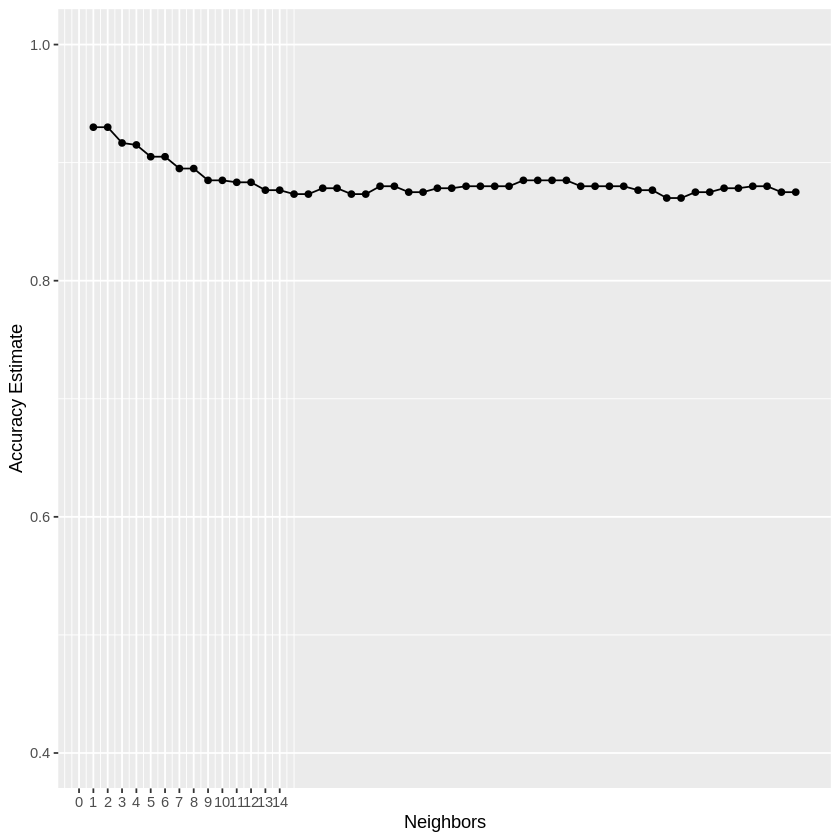

In [20]:
#cross-validate and tune the model using a 10-fold cross-validation
pokemon_vfold <- vfold_cv(pokemon_train, v = 10, strata = Legendary)

kvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

pokemon_k_test <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_spec) |>
    tune_grid(resamples = pokemon_vfold, grid = kvals) |>
    collect_metrics()

accuracies <- pokemon_k_test |>
    filter(.metric == "accuracy")
accuracies

k_val_plot <-  ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
k_val_plot



In [ ]:
#create a new model with k = 5
pokemon_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
                set_engine("kknn") |>
                set_mode("classification")

pokemon_fit <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_spec) |>
    fit(data = pokemon_train)
pokemon_fit


In [ ]:
pokemon_predictions <- predict(pokemon_fit, pokemon_train) |>
                     bind_cols(pokemon_train) 
pokemon_predictions    

pokemon_metrics <- pokemon_predictions |>
                 metrics(truth = Legendary, estimate = .pred_class) |>
                 filter(.metric == "accuracy")
pokemon_metrics

pokemon_conf_mat <- pokemon_predictions |>
                  conf_mat(truth = Legendary, estimate = .pred_class)

pokemon_conf_mat